# Fitting a model to data using **zeus**

## Let us first import some useful packages including **zeus**

In [16]:
import zeus
import numpy as np 
import matplotlib.pyplot as plt

print('zeus version:', zeus.__version__)

zeus version: 2.3.0


## The generative model

Lets define a sinusoidal model with Gaussian uncorrelated measurement errors.

$$ y = A \sin \Bigg[ 2\pi \Big(\frac{t}{P}+t_{0}\Big)\Bigg] + B + \epsilon$$

where $\epsilon \sim \mathcal{N}(0,\sigma^{2})$.

In [10]:
def sine_model(params, t):
    A, B, P, t0 = params
    return A * np.sin((t / P + t0) * 2 * np.pi) + B

We can now use the model to generate some synthetic data/observations. To this end we first need to define the time instances in which we "took" our measurements as well as how many such measurements we obtained.

In [124]:
np.random.seed(42)

# Number of data points
n_data = 50

# time of observations
t = np.random.uniform(0, 5, size=n_data)

Our next step is to decide what are the "true" values of the parameters and generate the data assuming a measurement error (standard deviation) of $\sigma = 1.0$.

In [125]:
# A=4.3, B=1.0, P=3.1, t=0.4
params_true = [4.3, 1.0, 3.1, 0.4]

yerr = 1.0
y = np.random.normal(sine_model(params_true, t), yerr)

Now we can plot the data.

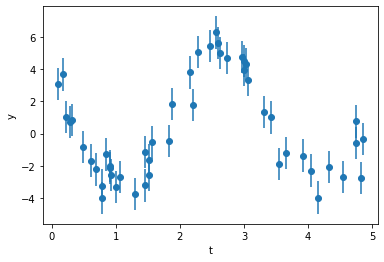

In [126]:
plt.figure()
plt.errorbar(x=t, y=y, yerr=yerr, marker='o', ls=' ')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

## Prior, Likelihood and Posterior

In [127]:
def log_prior(params):
    A, B, P, t0 = params

    if np.abs(B)>10.0 or A<0.1 or A>100.0 or P<0.3 or P>10.0 or t0<0.0 or t0>1.0:
        return -np.inf
    return 0.0

In [128]:
def log_like(params):
    # compute for each t point, where it should lie in y
    y_model = sine_model(params, t)
    # compute likelihood
    loglike = -0.5 * (((y_model - y) / yerr)**2).sum()

    return loglike

In [129]:
def log_post(params):
    lp = log_prior(params)
    if ~np.isfinite(lp):
        return -np.inf 
    return lp + log_like(params)

## Maximum a Posteriori (MAP) estimate

In [144]:
from scipy.optimize import minimize

results = minimize(lambda x : -log_post(x), p0, method='Nelder-Mead', options={'maxiter':2000, 'disp':True})

print('p =', results.x)

Optimization terminated successfully.
         Current function value: 20.540879
         Iterations: 76
         Function evaluations: 123
p = [4.21923235 0.98576703 3.10960913 0.39962441]


## Markov Chain Monte Carlo with **zeus**

In [145]:
ndim = 4 
nwalkers = 10
nsteps = 1000

start = results.x + 0.001 * np.random.randn(nwalkers, ndim)

In [146]:
sampler = zeus.EnsembleSampler(nwalkers, ndim, log_post)

sampler.run_mcmc(start, nsteps)

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 1000/1000 [00:02<00:00, 392.93it/s]


## Results

In [147]:
samples = sampler.get_chain()

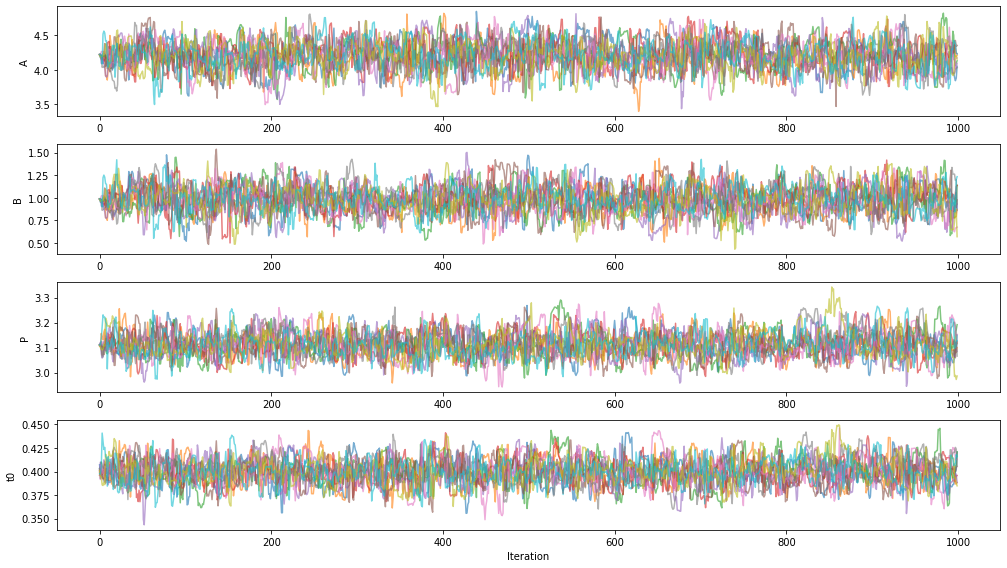

In [148]:
labels = ['A', 'B', 'P', 't0']

plt.figure(figsize=(14,8))
for i in range(ndim):
    plt.subplot(ndim,1,i+1)
    plt.plot(samples[:,:,i],alpha=0.6)
    plt.ylabel(labels[i])
plt.xlabel('Iteration')
plt.tight_layout()
plt.show()

/Users/minas/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  **contour_kws,
/Users/minas/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  **contour_kws,
/Users/minas/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  **contour_kws,
/Users/minas/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  **contour_kws,
/Users/minas/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  **contour_kws,
/Users/minas/anaconda3/envs/nbodykit-env/lib/python3.7/

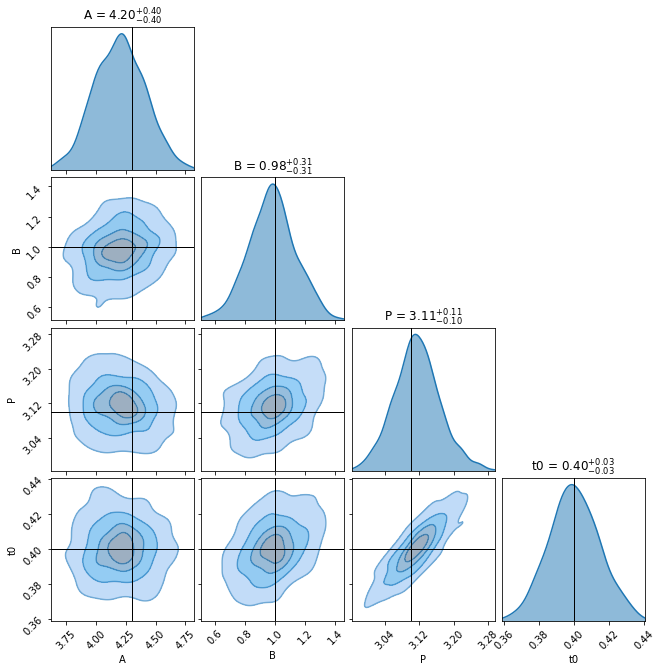

In [151]:
chain = sampler.get_chain(flat=True, discard=0.5, thin=7)

zeus.cornerplot(chain, labels=labels, truth=params_true);

## Posterior Predictive Checks

In [140]:
t_range = np.linspace(0.0, 5.0, 1000)

obs = []

for s in chain:
    m = sine_model(s, t_range)
    obs.append(np.random.normal(m, yerr))

obs = np.array(obs)

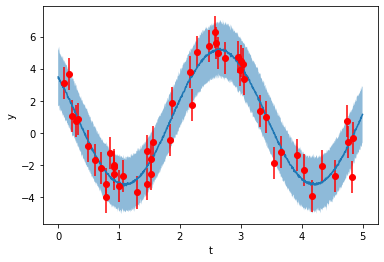

In [141]:
plt.fill_between(t_range, np.percentile(obs,5,axis=0),np.percentile(obs,95,axis=0),alpha=0.5)
plt.plot(t_range, np.mean(obs, axis=0))
plt.errorbar(x=t, y=y, yerr=yerr, marker='o', ls=' ', color='red')
plt.xlabel('t')
plt.ylabel('y')
plt.show()